# Forward modeling of isotropic diffusion of cations in minerals: Sr diffusion in hornblende

_Jordan Lubbers_ <br>
_Alaska Volcano Observatory_

Sr tracer-diffusion in hornblende follows an Arrhenius relationship and has been determined to be:

$$ D\_{Sr} = 4.9x10^{-8}e^{\left(\frac{-260kJ}{RT}\right)}$$

parallel to the c axis (Brabander and Giletti, 1995). Below we will develop a model to quantify the degree of diffusion that has occured from an initial profile in hornblende using the explicit finite difference method applied to Fick's $2^{nd}$ Law. The solution for this discretization is:

$$C_{i,j+1} = C_{i,j}+D\Delta t\left[\frac{C_{i+1,j}-2C_{i,j}+C_{i-1,j}}{\Delta x^2}\right]$$

Numerical stability is achieved by satisfying the Courant condition:

$$ \frac{D\Delta t}{\Delta x^2} < 0.5 $$

This is preferred over the analytical solution to Fick's $2^{nd}$ Law (e.g., Crank 1975) as it offers more freedom in inital boundary conditions that are not step functions.

## General model parameters

- **Temperature:** 750 degrees. This is a fairly general 'lock up' temperature for large silicic magma reservoirs (Bradshaw et al., 2021). As this is the thermal history we are concerned about quantifying, we choose this temperature for our models. Therefore, all diffusion times represent the duration a given grain (or zone of a grain) has spent above 750 degrees
- **Boundary conditions:** These are based on the shape of slower diffusing elements that show a positive correlation with Sr (e.g., Zr). As those are more likely to reflect the initial boudary conditions of that chemical zone, we prefer this over assuming step functions. Initial step function boundary conditions when Zr profiles are more relaxed would result in a drastic overestimation of how much diffusion has actually occured.

# Importing data


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interp
import seaborn as sns

import glob as glob
import sys

# path to default plotting preferences script
# if you don't have one just comment out the following lines
sys.path.append(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\QuatResearch23_tephra_classification"
)
import mpl_defaults

import plag_diff as plag


# random profile from your y and yerr
def random_profile(x, y, yerr):
    """random_profile generates a random observed profile for diffusion modeling that is based of the measured value
    and its corresponding uncertainty at each point.
            Inputs:
            x = x data
            y = y data
            yerr = 1 sigma uncertainty on y data measurements. If your data has 2 sigma uncertainties, just
            create a new variable that divides it by 2 so you have 1 standard deviation uncertainties

            Returns:
            yrand = random y data points who's liklihood is normally distributed around the mean
    """

    # np.random.normal(mean,std deviation)
    yrand = np.random.normal(loc=y, scale=yerr)
    return yrand


def diffusivity(Do, E, T):
    """diffusivity calculates the diffusivity of an element that follows
    basic Arrhenius relationship in the form Di = Do(e^{-E/RT}).
                Inputs:
                Do = pre-exponent factor (m^2/s)
                E = Activation energy (J/mol)
                T = Temperature (K)

                Returns:
                Di = Arrhenius diffusion coefficient for a given
                element in a given mineral in um^2/s"""
    import math

    R = 8.314  # J/Kmol
    Di = (Do * math.exp(-E / (R * T))) * 1e12
    return Di


def Monte_Carlo_FD_long(n, limit):
    best_fits = [] * n
    x = np.linspace(np.min(dist), np.max(dist), nx)

    for i in tqdm(range(0, n)):
        u_n = initial_profile.copy()

        yrand = random_profile(dist, te, te_unc)
        f_rand = interp.interp1d(dist, yrand)
        rand_interp = f_rand(x)

        # creating a container to put all of your curve iterations
        curves = np.zeros((nt, nx))
        # courant condition (this must be <.5)
        # iterating over the length of nt(each iteration is a time step)
        F = Sr_di * dt / dx**2
        if F >= 0.5:
            print(
                "You do not have numerical stability, please adjust your grid accordingly"
            )
        else:
            for n in range(0, int(nt)):
                u[1 : nx - 1] = u_n[1 : nx - 1] + F * (
                    u_n[0 : nx - 2] - 2 * u_n[1 : nx - 1] + u_n[2:nx]
                )
                u[0] = u_n[0] + F * (u_n[1] - 2 * u_n[0] + u_n[1])
                # u[0] = step_left  # fixing your boundary conditions with above values
                u[-1] = te[-1]
                #             u[-1] = Cr
                curves[n, :] = u  # saving your iteration to your curve container
                u_n[:] = u  # switch your variables before the next iteration
                # makes your current u vals the u_n vals in the next loop

        chi2 = abs(
            np.sum(
                (rand_interp[None, :] - curves) ** 2 / (rand_interp[None, :]), axis=1
            )
        )
        chi2_min = np.min(chi2)
        fit_idx = np.argwhere(chi2 == chi2_min)
        fit_idx = fit_idx[0].item()
        bf_time_mc = fit_idx + 1

        best_fits.append(bf_time_mc)


    return best_fits



# Create a dataframe from your uploaded file
data = pd.read_excel(r"test_data/amph_diffusion_test_data.xlsx")

grain_data = data.set_index("grain")

grainlist = list(grain_data.index.unique())
print(grainlist)

['MQA20']


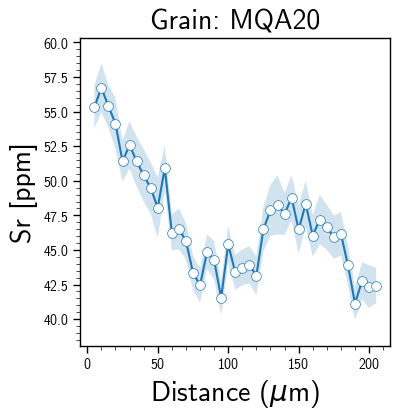

In [2]:
# Choose grain
grain = "MQA20"

# choose the starting and stopping point for the part of the profile you want to use
clip_start = 0
clip_stop = 0
dist_original = grain_data.loc[grain, "distance"].to_numpy()
prof_length = len(dist_original)
dist_all = dist_original[clip_start : prof_length - clip_stop]


start = 0
stop = 0


# measured trace element information
te_all = grain_data.loc[grain, "Sr"][clip_start : prof_length - clip_stop]
te_unc_all = grain_data.loc[grain, "Sr_se"][clip_start : prof_length - clip_stop]


# trace element information for the model interval
te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]

# for consistent colors throughout
obs_color = "#1f77b4"  # observed data
init_color = "#000000"  # initial profile related data
bf_color = "#2ca02c"
check_color = "#d62728"

# plot observed data and initial condition
fig, ax = plt.subplots(figsize=(4, 4))
# observed profile
ax.plot(dist, te, marker="o", ls="-", mfc="w", mec=obs_color)
ax.fill_between(dist, te + te_unc, te - te_unc, facecolor=obs_color, alpha=0.2)
ax.set_title("Grain: {}".format(grain), fontsize=20)
# ax.legend(loc = 'upper left')
ax.set_ylabel("Sr [ppm]", fontsize=20)
ax.set_xlabel("Distance ($\mu$m)", fontsize=20)
ax.minorticks_on()

# Thermodynamic parameters and $D_{Sr}$


In [3]:
# Constants
# Temperature Kelvin
T_K = 820 + 273.15
# Celsius
T_C = T_K - 273

sinyear = 60 * 60 * 24 * 365.25

# conditions for calculating diffusivity of element in mineral
# Sr in amphibole from Brabander and Giletti 1995
Do = 4.9 * 10**-8
E = 260e3


# Sr diffusion in hornblende
Sr_di = diffusivity(Do, E, T_K)
# lowest resolvable timescale per Bradshaw and Kent (2017)
t20 = (0.24 * (((5) * 1e-6) ** 2) / (Sr_di / 1e12)) / sinyear
t20

10.30470011379735

## Using a "slow diffusing" element to get initial profile shape

If you have elements that diffuse significantly slower than the one that you are trying to model but behave similarly w.r.t. partitioning this may be a good way to check for a rough idea of where diffusion started. Below we use Zr in amphibole as it is likely a slow diffuser (i.e., highly charged and relatively large).


Text(0.5, 0, 'Distance ($\\mu$m)')

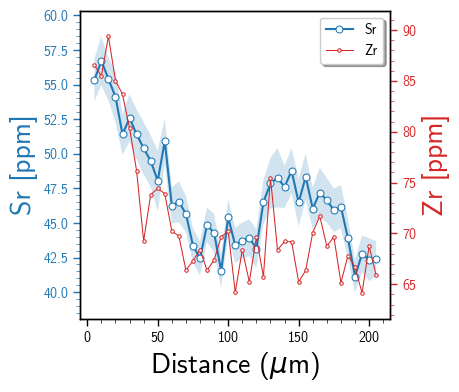

In [4]:
check_element = "Zr"

# plot observed data
fig, ax = plt.subplots(figsize=(4, 4))
# observed profile and subset
(l1,) = ax.plot(
    dist,
    te,
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    ms=5,
    mew=0.75,
    label="Sr",
)
ax.fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)

ax2 = ax.twinx()
(l2,) = ax2.plot(
    dist,
    grain_data.loc[grain, check_element][start : len(te_all) - stop],
    c=check_color,
    marker=".",
    mfc="w",
    mec=check_color,
    ms=5,
    mew=0.75,
    lw=0.75,
    label=check_element,
)
ax2.tick_params(axis="y", which="both", colors=check_color)
ax2.set_ylabel(f"{check_element} [ppm]", c=check_color)

ax.legend(handles=[l1, l2], fancybox=True, shadow=True)
# fig.legend(loc="best")

ax.set_ylabel("Sr [ppm]", c=obs_color)
ax.tick_params(axis="y", which="both", colors=obs_color)
ax.set_xlabel("Distance ($\mu$m)")

## Set up initial profile

This is where the diffusion model starts. Many modelers will refer to these as "step functions" as they make the assumption that melt (and by proxy mineral chemistry) changes are happening instantaneously relative to crystal growth. If you believe that this is _not_ the case, you can change your initial profile accordingly! It gets a little trickier to code, but it can be done using things like interpolation between two endmembers, which effectively makes more diagonal lines.


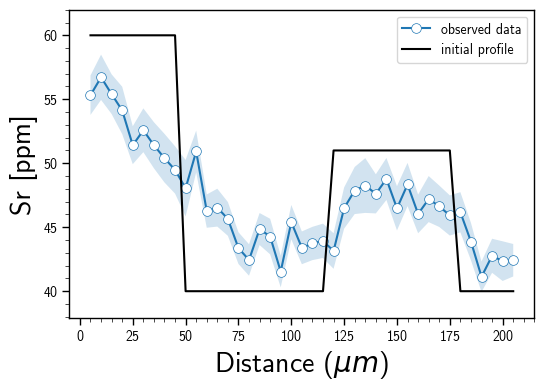

In [5]:
# this multiplies the amount of of x points you have effectively 'filling in' your x grid
multiplier = 1
# setting up your finite difference with a specified number of x points
# here we are saying to add 5 times as many interpolated points as observed points

# number of points in your xgrid
nx = len(dist) * multiplier
# creating your xgrid
x = np.linspace(np.min(dist), np.max(dist), nx)
# x spacing
dx = x[1] - x[0]
# since our Di is in um^2/s we need to factor that into our time grid
# by spacing out the points accordingly.
iterations = int(18250)
sinyear = 60 * 60 * 24 * 365.25
tenthsofyear = sinyear / 10
days = sinyear / 365.25
sinday = 60 * 60 * 24

# creating a time grid that is spaced by years
t = np.arange(0, iterations * sinyear + 1, sinyear)
dt = t[1] - t[0]
nt = len(t)


step_start = [50,180]
step_stop = [120,290]
step_left = [60,51]
step_middle = [40,40]
step_right = [51,36]

#
initial_profile = plag.create_stepped_profile(dist, step_start,step_stop,step_left,step_middle,step_right)
fig, ax = plt.subplots()

ax.plot(dist, te, marker="o", ls="-", mfc="w", mec=obs_color, label="observed data")
ax.fill_between(dist, te + te_unc, te - te_unc, facecolor=obs_color, alpha=0.2)
ax.plot(x, initial_profile, "k-", label="initial profile")


ax.set_ylabel("Sr [ppm]", fontsize=20)
ax.set_xlabel("Distance ($\mu m$)", fontsize=20)
ax.legend(loc="best")

# Implementing the diffusion equation


In [6]:
# creating a container to put all of your curve iterations
curves = np.zeros((nt, nx))
# courant condition (this must be <.5)
# iterating over the length of nt(each iteration is a time step)
F = Sr_di * dt / dx**2

# containers for each iteration
# unknown at current iteration
u = np.zeros(nx)
# this will eventually be the previous iteration, but we start it at 
# our initial profile
u_n = initial_profile.copy()
if F >= 0.5:
    print("You do not have numerical stability, please adjust your grid accordingly")
else:
    for n in tqdm(range(0, int(nt))):
        u[1 : nx - 1] = u_n[1 : nx - 1] + F * (
            u_n[0 : nx - 2] - 2 * u_n[1 : nx - 1] + u_n[2:nx]
        )
        u[0] = u_n[0] + F * (u_n[1] - 2 * u_n[0] + u_n[1])
        # u[0] = step_left  # fixing your boundary conditions with above values
        u[-1] = te[-1]
        #             u[-1] = Cr
        curves[n, :] = u  # saving your iteration to your curve container
        u_n[:] = u  # switch your variables before the next iteration
        # makes your current u vals the u_n vals in the next loop

  0%|          | 0/18251 [00:00<?, ?it/s]

# Finding the best fit

Here we will implement a basic $\chi^2$ minimization to find the best fit iteration. This quantifies the overall deviation for a given diffusion profile from the observed profile by:

$$ \chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}$$

where $O_i$ is a given spot, $i$ in the diffusion model at time $j$, and $E_i$ is the observed data at that point in the distance grid.


In [7]:
chi2 = abs(
    np.sum((curves - te.to_numpy()[None, :]) ** 2 / (te.to_numpy()[None, :]), axis=1)
)
chi2_min = np.min(chi2)
fit_idx = np.argwhere(chi2 == chi2_min)
fit_idx = fit_idx[0].item()
bf_time = fit_idx + 1
bf_time

885

# Visualize the results


Text(0.5, 0.98, 'Grain: MQA20')

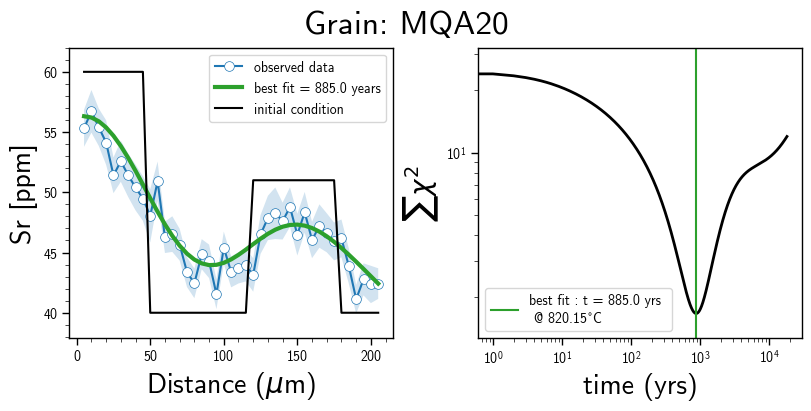

In [9]:
# make iterations to years we have to divide by 365 since we iterate in days
makeyears = 1

fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")

ax[0].plot(dist, te, marker="o", ls="-", mfc="w", mec=obs_color, label="observed data")
ax[0].fill_between(dist, te + te_unc, te - te_unc, facecolor=obs_color, alpha=0.2)

ax[0].plot(
    x,
    curves[bf_time - 1],
    ls="-",
    c=bf_color,
    label="best fit = {} years".format(np.round(bf_time / makeyears, 2)),
    lw=3,
)
ax[0].plot(x, initial_profile, ls="-", c=init_color, label="initial condition")
ax[0].minorticks_on()
ax[0].legend(loc="best")
ax[0].set_ylabel("Sr [ppm]", fontsize=20)
ax[0].set_xlabel("Distance ($\mu$m)", fontsize=20)

# chi-squared plot
# convert to days
tdays = t / dt
# chi-squared curve

ax[1].plot(
    tdays / makeyears,
    chi2,
    "-k",
    lw=2,
)

# vertical line at best fit value
ax[1].axvline(
    bf_time / makeyears,
    color=bf_color,
    label="best fit : t = {} yrs \n @ {}$^{{\circ}}$C".format(
        np.round(bf_time / makeyears, 2), np.round(T_K - 273,2)
    ),
)
ax[1].set_xlabel(
    "time (yrs)",
)
ax[1].set_ylabel(
    "$\sum{\chi^2} $",
)
ax[1].set_xscale("log")
ax[1].legend(
    loc="best",
)
ax[1].set_yscale("log")
fig.suptitle("Grain: {}".format(grain), fontsize=24)


# Monte Carlo diffusion model

This uses the analytical uncertainty in your profile to random profile. This random profile is constructed by generating a normally distributed random value at each point in the profile that is dictated by the mean value and it's one-sigma uncertainty. Each random profile is then run through the diffusion model outlined above and a best fit diffusion time is assigned to it.


In [11]:
# run the monte carlo simulation a desired number of times. Put an upper limit on it.
# This is really only an issue if you have large uncertainties in your data which may cause erroneous
# profiles


limit = 1e5  # 10000 years

n = 1000

best_fits = Monte_Carlo_FD_long(n, limit)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Grain: MQA20 T = 820.0$^{\\circ}$C')

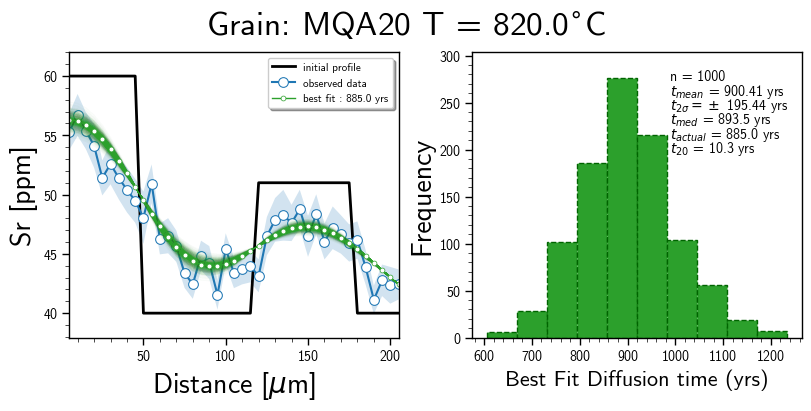

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
ax[0].plot(dist, initial_profile, ls="-", c=init_color, lw=2, label="initial profile")
ax[0].plot(
    dist,
    te,
    label="observed data",
    c=obs_color,
    marker="o",
    mfc="w",
    mec=obs_color,
    mew=0.75,
)
ax[0].fill_between(dist, te + te_unc, te - te_unc, alpha=0.2)
for fit in best_fits:
    ax[0].plot(
        dist,
        curves[fit],
        c=bf_color,
        ls="-",
        lw=1,
        alpha=0.01,
    )

ax[0].plot(
    dist,
    curves[bf_time],
    marker=".",
    mfc="w",
    c=bf_color,
    mec=bf_color,
    lw=1,
    label="best fit : {} yrs".format(np.round(bf_time / makeyears, 2)),
)

ax[0].legend(loc="best", prop={"size": 8}, ncol=1, fancybox=True, shadow=True)
ax[0].set_ylabel("Sr [ppm]", fontsize=20)
ax[0].set_xlim(left=np.min(dist), right=np.max(dist))
ax[0].set_xlabel("Distance [$\mu$m]", fontsize=20)


mc_results = np.array(best_fits) / makeyears
# mc_results = mc_results[mc_results > 300]
counts, bins, patches = ax[1].hist(
    mc_results,
    facecolor=bf_color,
    edgecolor="darkgreen",
    linestyle="--",
)

transform = None
if transform:
    (
        transform_mc_results,
        transform_mean,
        transform_median,
        transform_low,
        transform_high,
    ) = plag.transform_data(mc_results, kind=transform)

    ax[1].text(
        0.55,
        0.9,
        "n = {}".format(mc_results.shape[0]),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.55,
        0.85,
        "$t_{{mean}}$ = {} yrs".format(np.round(transform_mean, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.55,
        0.8,
        "$t_{{2\sigma}} = \pm$ {} ; {} yrs".format(
            np.round(transform_mean - transform_low, 2),
            np.round(transform_high - transform_mean, 2),
        ),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.55,
        0.75,
        "$t_{{med}}$ = {} yrs".format(np.round(transform_median, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.55,
        0.7,
        "$t_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.55,
        0.65,
        "$t_{{20}}$ = {} yrs".format(np.round(t20, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )


else:
    ax[1].text(
        0.6,
        0.9,
        "n = {}".format(mc_results.shape[0]),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.6,
        0.85,
        "$t_{{mean}}$ = {} yrs".format(np.round(mc_results.mean(), 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.6,
        0.8,
        "$t_{{2\sigma}} = \pm$ {} yrs".format(np.round(2 * np.std(mc_results), 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.6,
        0.75,
        "$t_{{med}}$ = {} yrs".format(np.round(np.median(mc_results), 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.6,
        0.7,
        "$t_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )
    ax[1].text(
        0.6,
        0.65,
        "$t_{{20}}$ = {} yrs".format(np.round(t20, 2)),
        transform=ax[1].transAxes,
        fontsize=10,
    )


ax[1].set_xlabel("Best Fit Diffusion time (yrs)", fontsize=16)
ax[1].set_ylabel("Frequency")
fig.suptitle(f"Grain: {grain} T = {np.round(T_K - 273.15,2)}$^{{\circ}}$C", fontsize=24)


## Exporting relevant metadata

In [14]:
if transform:
    output_dict = {
        "grain": grain,
        "step start (idx)": step_start,
        "step stop (idx)": step_stop,
        "left concentration (ppm)": step_left,
        "middle concentration (ppm)": step_middle,
        "right concentration (ppm)": step_right,
        "best fit (yrs)": bf_time / makeyears,
        "mc mean (yrs)": transform_mean,
        "mc 2sig (yrs)": [transform_low, transform_high],
    }

else:
    output_dict = {
        "grain": grain,
        "step start (idx)": step_start,
        "step stop (idx)": step_stop,
        "left concentration (ppm)": step_left,
        "middle concentration (ppm)": step_middle,
        "right concentration (ppm)": step_right,
        "best fit (yrs)": bf_time / makeyears,
        "mc mean (yrs)": np.mean(mc_results),
        "mc 2sig (yrs)": np.std(mc_results) * 2,
    }

pd.DataFrame([output_dict])

,grain,step start (idx),step stop (idx),left concentration (ppm),middle concentration (ppm),right concentration (ppm),best fit (yrs),mc mean (yrs),mc 2sig (yrs)
0,MQA20,"[50, 180]","[120, 290]","[60, 51]","[40, 40]","[51, 36]",885.0,900.408,195.444187
